In [1]:
%matplotlib inline


# Self-supervised learning on EEG with relative positioning

This example shows how to train a neural network with self-supervision on sleep
EEG data. We follow the relative positioning approach of [1]_ on the openly
accessible Sleep Physionet dataset [2]_ [3]_.

.. topic:: Self-supervised learning

    Self-supervised learning (SSL) is a learning paradigm that leverages
    unlabelled data to train neural networks. First, neural networks are
    trained on a "pretext task" which uses unlabelled data only. The pretext
    task is designed based on a prior understanding of the data under study
    (e.g., EEG has an underlying autocorrelation struture) and such that the
    processing required to perform well on this pretext task is related to the
    processing required to perform well on another task of interest.
    Once trained, these neural networks can be reused as feature extractors or
    weight initialization in a "downstream task", which is the task that we are
    actually interested in (e.g., sleep staging). The pretext task step can
    help reduce the quantity of labelled data needed to perform well on the
    downstream task and/or improve downstream performance as compared to a
    strictly supervised approach [1]_.

Here, we use relative positioning (RP) as our pretext task, and perform sleep
staging as our downstream task. RP is a simple SSL task, in which a neural
network is trained to predict whether two randomly sampled EEG windows are
close or far apart in time. This method was shown to yield physiologically- and
clinically-relevant features and to boost classification performance in
low-labels data regimes [1]_.
   :depth: 2


In [2]:
# Authors: Hubert Banville <hubert.jbanville@gmail.com>
#
# License: BSD (3-clause)


random_state = 87
n_jobs = 4

## Loading and preprocessing the dataset

### Loading the raw recordings

First, we load a few recordings from the Sleep Physionet dataset. Running
this example with more recordings should yield better representations and
downstream classification performance.



In [3]:
# from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datautil.serialization import  load_concat_dataset
import mne
mne.set_log_level('ERROR') 
# dataset = SleepPhysionet(
#     subject_ids=[0, 1, 2], recording_ids=[1], crop_wake_mins=30)

train_folder = '/home/mila/m/mohammad-javad.darvishi-bayasi/scratch/medical/eeg/tuab/tuab_pp3'
train_folder = '/home/mila/m/mohammad-javad.darvishi-bayasi/scratch/medical/eeg/NMT/nmt_pp3'

# dataset = load_concat_dataset(train_folder, preload=False,
#                             # target_name=['pathological','age','gender'] ,#)
#                             # ids_to_load=range(1000)
# )

In [4]:

# with io.capture_output() as captured:
# Load your EEG BIDS dataset using mne-bids
from mne_bids import BIDSPath, read_raw_bids
import mne
mne.set_log_level('ERROR') 
# bids_root = "../../CAE/BIDS_EXPORT/" # change this to your actual path
bids_root = "~/scratch/medical/eeg/CAE/BIDS_EXPORT_ICA" # change this to your actual path
# bids_root = train_folder # change this to your actual path
subject = "1" # change this to your subject ID
# session = "1" # change this to your subject ID
task = "aviation"
run = "1"
#_eeg
bids_path = BIDSPath(subject=subject, task=task, run=run, root=bids_root)
bids_paths = [BIDSPath(subject=str(subject), task=task, run=str(run), root=bids_root) for subject in range(1,25) for run in range(1,3)]
info = [(bids_path.subject, bids_path.run) for bids_path in bids_paths]

raw = mne.io.read_epochs_eeglab(bids_path)
sfreq = raw.info['sfreq']
raws_train = [mne.io.read_epochs_eeglab(bids_path) for bids_path in bids_paths]
for raw in raws_train:
    raw.events[:,2] = raw.events[:,2] - 1

# Convert the epochs to braindecode format using braindecode.datautil.signal_target
from misc import create_from_mne_epochs

common_ch = sorted(['C4', 'P3', 'F4', 'F8', 'Fp2', 'C3', 'Fz', 'Fp1', 'Cz', 'P4', 'O1', 'O2', 'F3', 'F7', 'Pz'])
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)
preprocessors = [
    # Preprocessor('pick_channels', ch_names=common_ch, ordered=True),
    Preprocessor('resample', sfreq=100),
]



window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_from_mne_epochs(
    # [raw,raw],
    raws_train,
    info,
    # trial_start_offset_samples=0,
    # trial_stop_offset_samples=0,
    # window_size_samples=5000,
    # window_stride_samples=1000,
    # drop_last_window=False,
    # descriptions=descriptions,
    # start_offset_samples=0,
    # stop_offset_samples=None,
    # preload=True,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    drop_last_window=True,
)

windows_dataset = preprocess(
    concat_ds=windows_dataset,
    preprocessors=preprocessors,
    n_jobs=4,
    # save_dir='./',
    overwrite=True,
)





In [5]:
raw.events
window_size_samples

3000

In [6]:
len(windows_dataset.datasets)
len(bids_paths)
windows_dataset.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,run,trial
0,0,14,3014,0,1,1,0
1,1,3014,6014,0,1,1,0
2,2,6014,9014,0,1,1,0
0,0,10907,13907,1,1,1,1
1,1,13907,16907,1,1,1,1
...,...,...,...,...,...,...,...
1,1,57479,60479,0,24,2,5
2,2,60479,63479,0,24,2,5
0,0,65372,68372,2,24,2,6
1,1,68372,71372,2,24,2,6


In [7]:
# # extra step for NMT: define subject_id
# import pandas as pd
# subject_id = range(len(dataset.datasets))
# for d, y in zip(dataset.datasets, subject_id):
#     d.description['subject'] = y
#     # d.target_name = 'pathological'
#     # d.target = d.description[d.target_name]
# dataset.set_description(pd.DataFrame([d.description for d in dataset.datasets]), overwrite=True)

### Preprocessing

Next, we preprocess the raw data. We convert the data to microvolts and apply
a lowpass filter. Since the Sleep Physionet data is already sampled at 100 Hz
we don't need to apply resampling.



In [8]:
# from braindecode.preprocessing.preprocess import preprocess, Preprocessor
# from numpy import multiply

# high_cut_hz = 30
# # Factor to convert from V to uV
# factor = 1e6

# preprocessors = [
#     Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
#     Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs)
# ]

# # Transform the data
# preprocess(dataset, preprocessors)

### Extracting windows

We extract 30-s windows to be used in both the pretext and downstream tasks.
As RP (and SSL in general) don't require labelled data, the pretext task
could be performed using unlabelled windows extracted with
:func:`braindecode.datautil.windower.create_fixed_length_window`.
Here however, purely for convenience, we directly extract labelled windows so
that we can reuse them in the sleep staging downstream task later.



In [9]:
# # extra step for Beyond: define subject_id
# import pandas as pd
# subject_id = range(len(windows_dataset.datasets))
# windows_dataset.set_description({"subject_id": subject_id}, overwrite=True)
# # for d, y in zip(windows_dataset.datasets, subject_id):
# #     d.set_description({"subject": y})
# #     description = {} #pd.DataFrame({"subject": y})
# #     # d.description['subject'] = y
# #     # d.target_name = 'pathological'
# #     # d.target = d.description[d.target_name]
# # dataset.set_description(pd.DataFrame([d.description for d in dataset.datasets]), overwrite=True)

In [10]:
# windows_dataset.description.head()

In [11]:
len(windows_dataset)

1080

### Preprocessing windows

We also preprocess the windows by applying channel-wise z-score normalization.



In [12]:
from sklearn.preprocessing import scale as standard_scale

# preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

### Splitting dataset into train, valid and test sets

We randomly split the recordings by subject into train, validation and
testing sets. We further define a new Dataset class which can receive a pair
of indices and return the corresponding windows. This will be needed when
training and evaluating on the pretext task.



In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from braindecode.datasets import BaseConcatDataset

subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target.
    """
    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)
        self.return_pair = True

    def __getitem__(self, index):
        if self.return_pair:
            ind1, ind2, y = index
            return (super().__getitem__(ind1)[0],
                    super().__getitem__(ind2)[0]), y
        else:
            return super().__getitem__(index)

    @property
    def return_pair(self):
        return self._return_pair

    @return_pair.setter
    def return_pair(self, value):
        self._return_pair = value


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

In [14]:
# for ds in windows_dataset.datasets:
# #     print(ds.description)

# subj_test
# df = windows_dataset.get_metadata()
# df[df['subject'].isin(subj_test)]

In [15]:
# raw.info

In [16]:
# splitted['valid'].get_metadata()


### Creating samplers

Next, we need to create samplers. These samplers will be used to randomly
sample pairs of examples to train and validate our model with
self-supervision.

The RP samplers have two main hyperparameters. `tau_pos` and `tau_neg`
control the size of the "positive" and "negative" contexts, respectively.
Pairs of windows that are separated by less than `tau_pos` samples will be
given a label of `1`, while pairs of windows that are separated by more than
`tau_neg` samples will be given a label of `0`. Here, we use the same values
as in [1]_, i.e., `tau_pos`= 1 min and `tau_neg`= 15 mins.

The samplers also control the number of pairs to be sampled (defined with
`n_examples`). This number can be large to help regularize the pretext task
training, for instance 2,000 pairs per recording as in [1]_. Here, we use a
lower number of 250 pairs per recording to reduce training time.



In [17]:
# splitted['valid'].get_metadata()#.groupby(['run','subject','trial']).count()

In [18]:
from braindecode.samplers import RelativePositioningSampler

tau_pos, tau_neg = int(sfreq * 0.5 * 60), int(sfreq * 1 * 60)
n_examples_train = 500 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True, random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True, random_state=random_state).presample()

In [19]:
train_sampler.__len__()

105000

## Creating the model

We can now create the deep learning model. In this tutorial, we use a
modified version of the sleep staging architecture introduced in [4]_ -
a four-layer convolutional neural network - as our embedder.
We change the dimensionality of the last layer to obtain a 100-dimension
embedding, use 16 convolutional channels instead of 8, and add batch
normalization after both temporal convolution layers.

We further wrap the model into a siamese architecture using the
# :class:`ContrastiveNet` class defined below. This allows us to train the
feature extractor end-to-end.



In [20]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode.models import Deep4Net,ShallowFBCSPNet,EEGNetv4, TCN


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 100

emb = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=emb_size,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

n_start_chans = 25
final_conv_length = 1
n_chan_factor = 2
stride_before_pool = True
emb = Deep4Net(
            n_channels, n_classes=emb_size,
            n_filters_time=n_start_chans,
            n_filters_spat=n_start_chans,
            input_window_samples=input_size_samples,
            n_filters_2=int(n_start_chans * n_chan_factor),
            n_filters_3=int(n_start_chans * (n_chan_factor ** 2.0)),
            n_filters_4=int(n_start_chans * (n_chan_factor ** 3.0)),
            final_conv_length='auto',#final_conv_length,
            stride_before_pool=stride_before_pool,
            drop_prob=0.25)

class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        return self.clf(torch.abs(z1 - z2)).flatten()


model = ContrastiveNet(emb, emb_size).to(device)

/home/mila/m/mohammad-javad.darvishi-bayasi/.conda/envs/braindecode/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


## Training

We can now train our network on the pretext task. We use similar
hyperparameters as in [1]_, but reduce the number of epochs and
increase the learning rate to account for the smaller setting of
this example.



In [21]:
import os

from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 512  # 512 if data large enough
n_epochs = 10
num_workers = 0 if n_jobs <= 1 else n_jobs

import datetime
now = datetime.datetime.now()
f_params_name = 'best_model_params_'+str(now)+'.pt'
print(f_params_name)

cp = Checkpoint(dirname='../ssl_pt/', f_params=f_params_name, f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss

# os.remove('./params.pt')  # Delete parameters file

best_model_params_2023-09-20 12:19:10.798769.pt
  epoch    train_acc    train_loss    valid_acc    valid_loss    cp       dur
-------  -----------  ------------  -----------  ------------  ----  --------
      1       0.5496        0.7026       0.5478        0.6870     +  208.8858
      2       0.8258        0.3831       0.5173        0.7937        162.9636
      3       0.9364        0.1744       0.5074        0.8117        165.2366
      4       0.9672        0.0965       0.4979        1.0087        175.0811
      5       0.9773        0.0712       0.5350        0.9463        166.9183
      6       0.9848        0.0463       0.5020        1.0767        169.8884
      7       0.9875        0.0393       0.4999        0.9290        166.2715
      8       0.9880        0.0372       0.5004        0.9024        164.7110
      9       0.9870        0.0427       0.5253        0.7916        166.5877
     10       0.9916        0.0264       0.5230        0.8340        168.0893


## Visualizing the results

### Inspecting pretext task performance

We plot the loss and pretext task performance for the training and validation
sets.



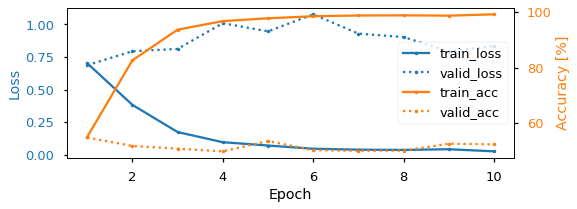

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()

We also display the confusion matrix and classification report for the
pretext task:



In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Switch to the test sampler
clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[4155 5125]
 [4301 5169]]
              precision    recall  f1-score   support

         0.0       0.49      0.45      0.47      9280
         1.0       0.50      0.55      0.52      9470

    accuracy                           0.50     18750
   macro avg       0.50      0.50      0.50     18750
weighted avg       0.50      0.50      0.50     18750



### Using the learned representation for sleep staging

We can now use the trained convolutional neural network as a feature
extractor. We perform sleep stage classification from the learned feature
representation using a linear logistic regression classifier.



In [24]:
# clf.initialize()  # This is important!

In [25]:
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Extract features with the trained embedder
data = dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [emb(batch_x.to(device)).cpu().numpy()
                 for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)

# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='lbfgs',
    multi_class='multinomial', random_state=random_state)
clf_pipe = make_pipeline(StandardScaler(), log_reg)

# Fit and score the logistic regression
clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on test set:')
print(confusion_matrix(data['test'][1], test_y_pred))
print(classification_report(data['test'][1], test_y_pred))

Sleep staging performance with logistic regression:
Train bal acc: 0.5389
Valid bal acc: 0.3053
Test bal acc: 0.3547
Results on test set:
[[24 33 27]
 [13 31 28]
 [20 25 24]]
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        84
           1       0.35      0.43      0.39        72
           2       0.30      0.35      0.32        69

    accuracy                           0.35       225
   macro avg       0.36      0.35      0.35       225
weighted avg       0.36      0.35      0.35       225



/home/mila/m/mohammad-javad.darvishi-bayasi/.conda/envs/braindecode/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The balanced accuracy is much higher than chance-level (i.e., 20% for our
5-class classification problem). Finally, we perform a quick 2D visualization
of the feature space using a PCA:



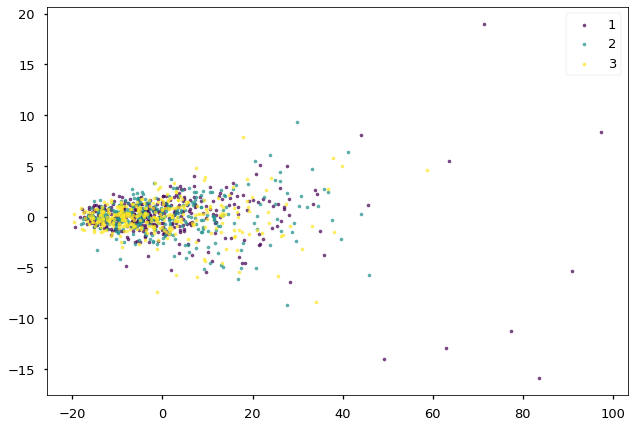

In [26]:
from sklearn.decomposition import PCA
from matplotlib import cm

X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

pca = PCA(n_components=2)
# tsne = TSNE(n_components=2)
components = pca.fit_transform(X)

fig, ax = plt.subplots()
colors = cm.get_cmap('viridis', 3)(range(3))
for i, stage in enumerate(['1', '2', '3']):#, 'N2', 'N3', 'R']):
    mask = y == i
    ax.scatter(components[mask, 0], components[mask, 1], s=10, alpha=0.7,
               color=colors[i], label=stage)
ax.legend()

We see that there is sleep stage-related structure in the embedding. A
nonlinear projection method (e.g., tSNE, UMAP) might yield more insightful
visualizations. Using a similar approach, the embedding space could also be
explored with respect to subject-level features, e.g., age and sex.

## Conclusion

In this example, we used self-supervised learning (SSL) as a way to learn
representations from unlabelled raw EEG data. Specifically, we used the
relative positioning (RP) pretext task to train a feature extractor on a
subset of the Sleep Physionet dataset. We then reused these features in a
downstream sleep staging task. We achieved reasonable downstream performance
and further showed with a 2D projection that the learned embedding space
contained sleep-related structure.

Many avenues could be taken to improve on these results. For instance, using
the entire Sleep Physionet dataset or training on larger datasets should help
the feature extractor learn better representations during the pretext task.
Other SSL tasks such as those described in [1]_ could further help discover
more powerful features.


## References

.. [1] Banville, H., Chehab, O., Hyvärinen, A., Engemann, D. A., & Gramfort, A.
      (2020). Uncovering the structure of clinical EEG signals with
      self-supervised learning. arXiv preprint arXiv:2007.16104.

.. [2] Kemp, B., Zwinderman, A. H., Tuk, B., Kamphuisen, H. A., & Oberye, J. J.
       (2000). Analysis of a sleep-dependent neuronal feedback loop: the
       slow-wave microcontinuity of the EEG. IEEE Transactions on Biomedical
       Engineering, 47(9), 1185-1194.

.. [3] Goldberger, A. L., Amaral, L. A., Glass, L., Hausdorff, J. M., Ivanov,
       P. C., Mark, R. G., ... & Stanley, H. E. (2000). PhysioBank,
       PhysioToolkit, and PhysioNet: components of a new research resource for
       complex physiologic signals. circulation, 101(23), e215-e220.

.. [4] Chambon, S., Galtier, M., Arnal, P., Wainrib, G. and Gramfort, A.
      (2018)A Deep Learning Architecture for Temporal Sleep Stage
      Classification Using Multivariate and Multimodal Time Series.
      IEEE Trans. on Neural Systems and Rehabilitation Engineering 26:
      (758-769)


